In [29]:
from IPython.core.display import display, HTML
display(HTML('<style>.container {width: 95% !important}</style>'))


C:\Users\Ian\AppData\Local\Temp\ipykernel_14468\1020233677.py:1: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


In [30]:
import math
import random
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline


In [31]:
def f(x):
  return 3*x**2 - 4*x + 5

In [32]:
f(3.0)


20.0

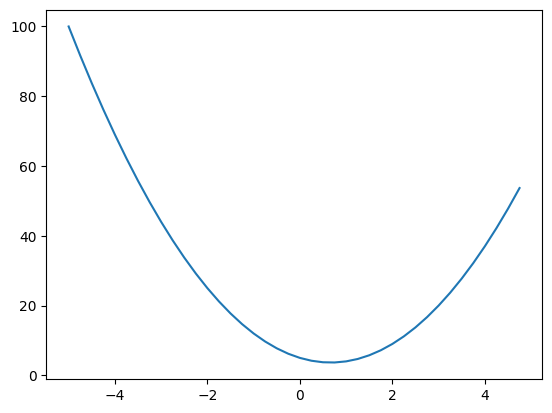

In [33]:
xs = np.arange(-5, 5, 0.25)
ys = f(xs)
plt.plot(xs, ys)

In [34]:
h = 0.000001
x = 2/3
(f(x + h) - f(x))/h

2.999378523327323e-06

In [35]:
a = 2.0
b = -3.0
c = 10.0
d = a*b + c
print(d)

4.0


In [36]:
h = 0.0001

# inputs
a = 2.0
b = -3.0
c = 10.0

d1 = a*b + c
c += h
d2 = a*b + c

print('d1', d1)
print('d2', d2)
print('slope', (d2 - d1)/h)

d1 4.0
d2 4.0001
slope 0.9999999999976694


In [37]:
class Value:
  
    def __init__(self, data, _children=(), _op='', label=''):
        self.data = data
        self.grad = 0.0
        self._backward = lambda: None
        self._prev = set(_children)
        self._op = _op
        self.label = label

    def __repr__(self):
        return f"Value(data={self.data})"

    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data + other.data, (self, other), '+')

        def _backward():
            self.grad += 1.0 * out.grad
            other.grad += 1.0 * out.grad
        out._backward = _backward

        return out
    
    def __neg__(self, other):
        return self * -1

    # Subtraction
    def __sub__(self, other):
        return self + (-other)

    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data * other.data, (self, other), '*')

        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
        out._backward = _backward

        return out
    
    def __pow__(self, other):
        assert isinstance(other, (int, float)), "only supporting int/float powers for now"
        out = Value(self.data**other, (self,), f'**{other}')

        def _backward():
            self.grad += other * (self.data ** (other - 1)) * out.grad
        out._backward = _backward

        return out
  
    def __rmul__(self, other): # other * self
        return self * other

    def __truediv__(self, other): # self / other
        return self * other**-1

    def __neg__(self): # -self
        return self * -1

    def __sub__(self, other): # self - other
        return self + (-other)

    def __radd__(self, other): # other + self
        return self + other


    def tanh(self):
        x = self.data
        t = (math.exp(2*x) - 1)/(math.exp(2*x) + 1)
        out = Value(t, (self, ), 'tanh')

        def _backward():
            self.grad += (1 - t**2) * out.grad
        out._backward = _backward
    
        return out
    
    def exp(self):
        x = self.data
        out = Value(math.exp(x), (self, ), 'exp')

        def _backward():
          self.grad += out.data * out.grad # NOTE: in the video I incorrectly used = instead of +=. Fixed here.
        out._backward = _backward

        return out


    def backward(self):

        topo = []
        visited = set()
        def build_topo(v):
          if v not in visited:
            visited.add(v)
            for child in v._prev:
              build_topo(child)
            topo.append(v)
        build_topo(self)
        self.grad = 1.0
        for node in reversed(topo):
          node._backward()

In [38]:
from graphviz import Digraph

def trace(root):
  # builds a set of all nodes and edges in a graph
  nodes, edges = set(), set()
  def build(v):
    if v not in nodes:
      nodes.add(v)
      for child in v._prev:
        edges.add((child, v))
        build(child)
  build(root)
  return nodes, edges

def draw_dot(root):
  dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right
  
  nodes, edges = trace(root)
  for n in nodes:
    uid = str(id(n))
    # for any value in the graph, create a rectangular ('record') node for it
    dot.node(name = uid, label = "{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape='record')
    if n._op:
      # if this value is a result of some operation, create an op node for it
      dot.node(name = uid + n._op, label = n._op)
      # and connect this node to it
      dot.edge(uid + n._op, uid)

  for n1, n2 in edges:
    # connect n1 to the op node of n2
    dot.edge(str(id(n1)), str(id(n2)) + n2._op)

  return dot

In [39]:
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
b = Value(6.8813735870195432, label='b')
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'
# activation function
o = n.tanh(); o.label='o'



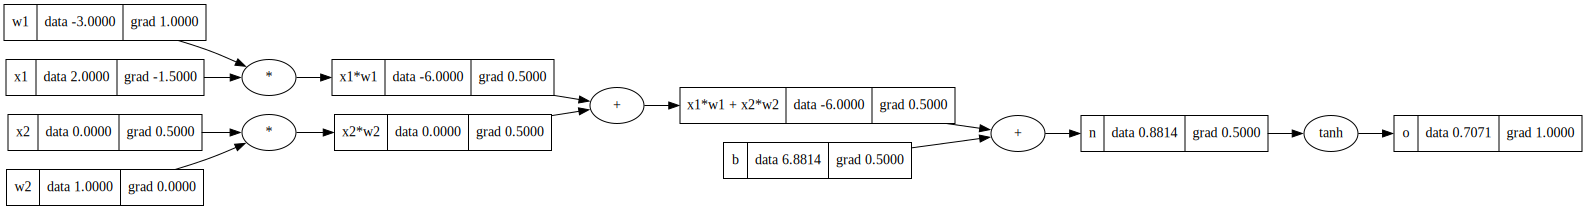

In [40]:
o.backward()
draw_dot(o)

In [41]:
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
b = Value(6.8813735870195432, label='b')
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'

# --------------------------------------
# e^2x-
e = ( 2 * n ).exp(); e.label = 'e'
o = ( e - 1 ) / ( e + 1 )
# ---------------------------------------
o.label='o'

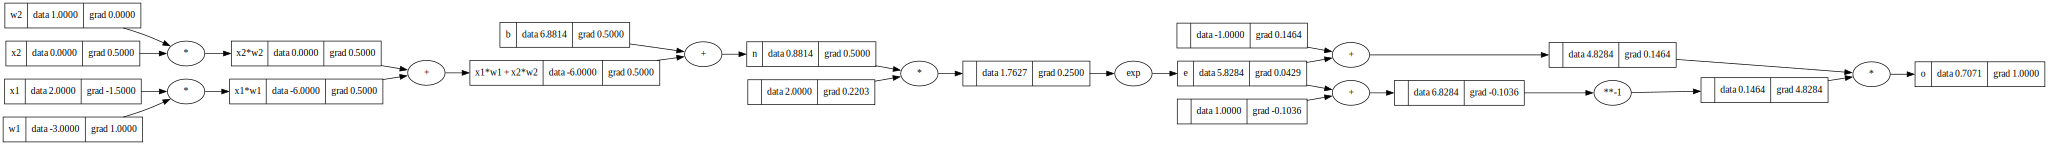

In [42]:
o.backward()
draw_dot(o)

In [43]:
import torch

In [51]:
class Neuron:
    def __init__(self, numOfInputs):
        self.w = [Value(random.uniform(-1, 1)) for _ in range(numOfInputs)]
        self.b = Value(random.uniform(-1, 1))

    def __call__(self, x):
        activation = sum((wi*xi for wi, xi in zip(self.w, x)), self.b)
        out = activation.tanh()
        return out
    
    def parameters(self):
        # list + list => list
        return self.w + [self.b]
    
class Layer:
    def __init__(self, numOfInputs, numOfOutputs):
        self.neurons = [Neuron(numOfInputs) for _ in range(numOfOutputs)]
    
    def __call__(self, x):
        outs = [n(x) for n in self.neurons]
        return outs[0] if len(outs) == 1 else outs
    
    def parameters(self):
        return [p for neuron in self.neurons for p in neuron.parameters()]


class MLP:
    def __init__(self, numOfInputs, numOfOutputs):
        size = [numOfInputs] + numOfOutputs
        self.layers = [Layer(size[i], size[i + 1]) for i in range(len(numOfOutputs))]

    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        return x

    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]

In [307]:
x = [2.0, 3.0, -1.0]
n = MLP(3, [4, 4, 1])
n(x)

Value(data=0.5776438851591902)

In [308]:
len(n.parameters())

41

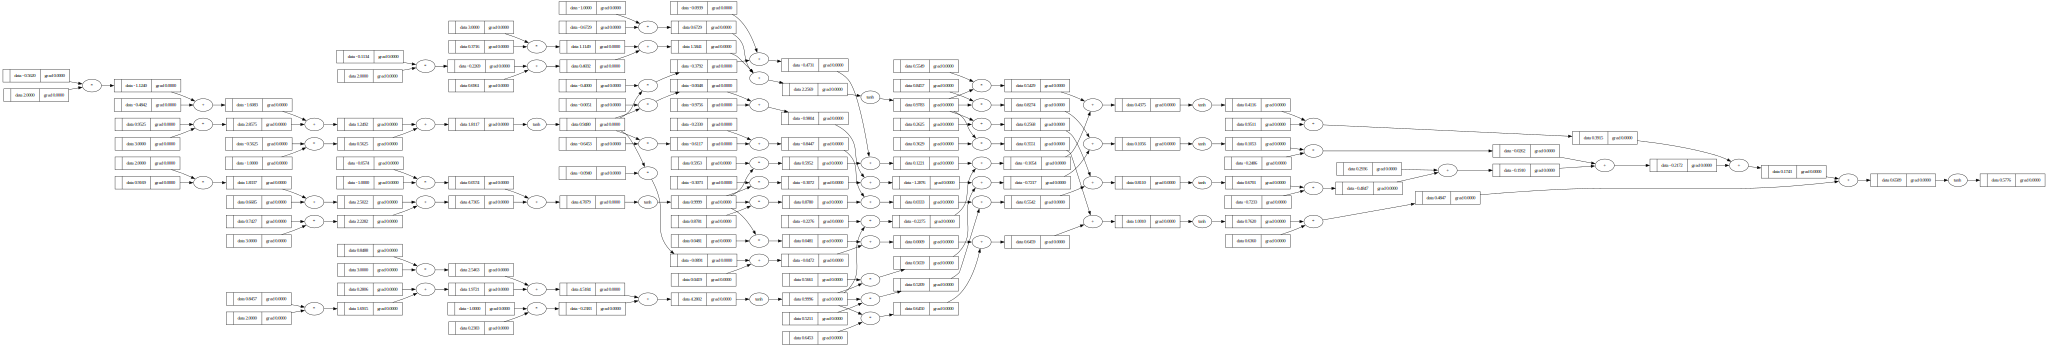

In [309]:
draw_dot(n(x))

In [310]:
# 4 possible inputs
xs = [
  [2.0, 3.0, -1.0], # desire 1.0
  [3.0, -1.0, 0.5], # desire -1.0
  [0.5, 1.0, 1.0],  # desire -1.0
  [1.0, 1.0, -1.0], # desire 1.0
]
ys = [1.0, -1.0, -1.0, 1.0] # 4 desired targets

In [315]:
for k in range(20):

    # forward pass
    ypred = [n(x) for x in xs]
    loss = sum([(yOutput - yGroundTruth)**2 for yGroundTruth, yOutput in zip(ys, ypred)])

    # backward pass
    for p in n.parameters():
        p = 0.0
    loss.backward()

    # update
    for p in n.parameters():
        p.data += -0.05 * p.grad

    print(k, loss.data)
    
ypred

0 4.721203385350788e-14
1 8.037898395838221e-16
2 2.0015076368379132e-17
3 2.7872050395009216e-17
4 4.1968277946718775e-17
5 6.325906245181076e-17
6 9.44034024600384e-17
7 1.3811151684226805e-16
8 1.9640040684187307e-16
9 2.6955053310436765e-16
10 3.5503002877835153e-16
11 4.468459618582413e-16
12 5.358047992860642e-16
13 6.109135750005244e-16
14 6.616846868019621e-16
15 6.80649196373799e-16
16 6.652051169539989e-16
17 6.181542327091564e-16
18 5.467997195660231e-16
19 4.610141618790526e-16


[Value(data=0.9999999999997039),
 Value(data=-1.0),
 Value(data=-1.0),
 Value(data=0.9999999785287597)]

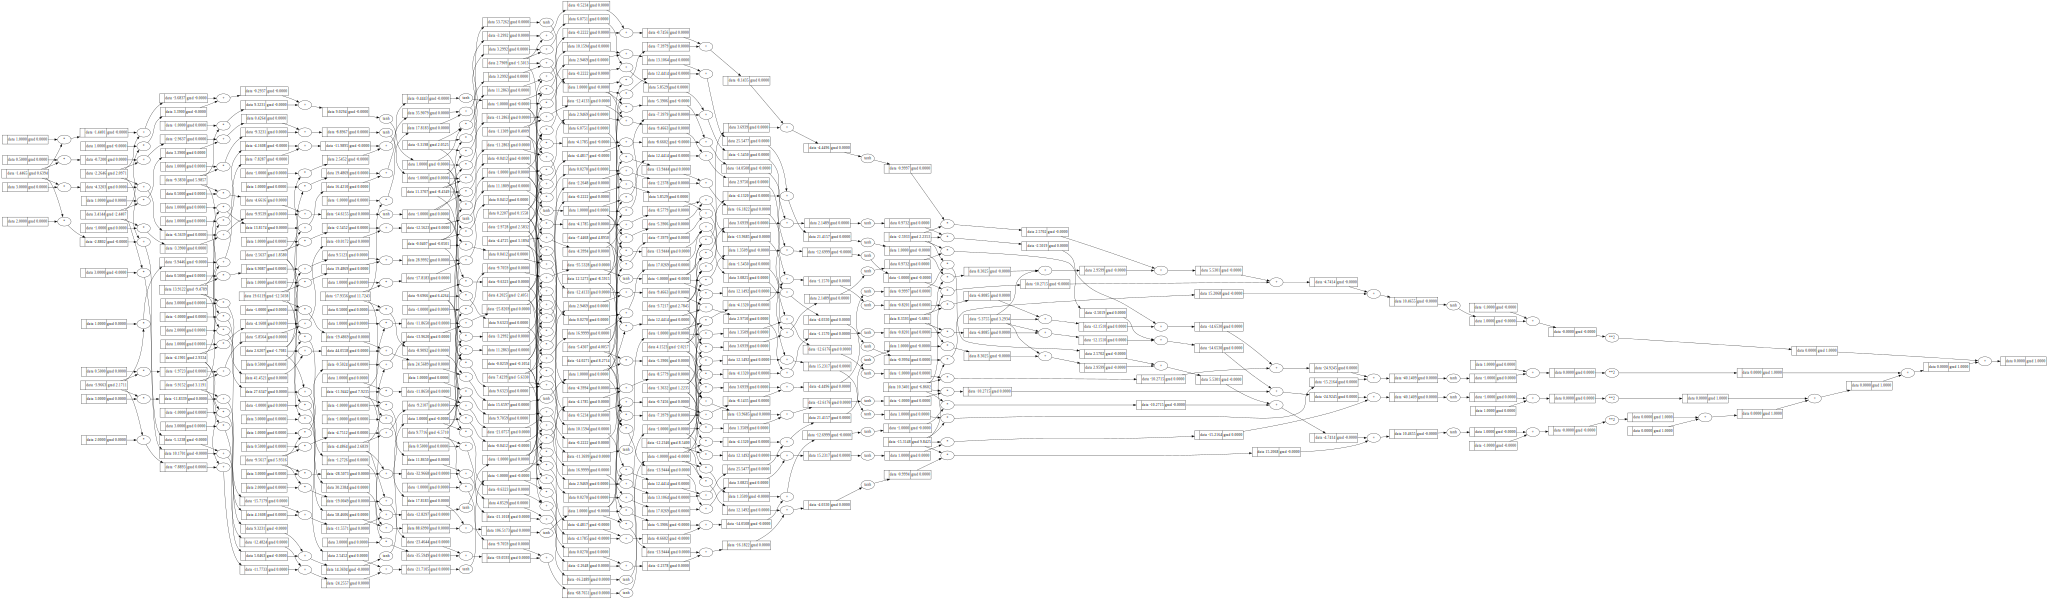

In [296]:
draw_dot(loss)